In [3]:
import xarray as xr
import urllib.request
import numpy as np
import pandas as pd
import os
from   datetime import datetime
import time
from   easymore.easymore import easymore
import sys

pwd = '../temporary/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'
file_name = 'SCDNA_v1.1.nc'

# create the path to the SCDNA file
if not os.path.isdir(pwd):
    os.mkdir(pwd)

# donwload the file if does not exists
outfile = pwd+file_name
if os.path.isfile(outfile) and os.stat(outfile).st_size > 1600000000: # file exists and larger thatn 1.6GB
    print('It seems the file exists; perhaps perviously downloaded; will skip downloading')
else:
    # download the file
    print('Downloading SCDNA; this may take a while ...')
    print('Downloading starts at: ', datetime.now())
    url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
    urllib.request.urlretrieve(url, outfile)
    print('Downloading ends at: ', datetime.now())

It seems the file exists; perhaps perviously downloaded; will skip downloading


In [5]:
# creation of three netcdf file with lat, lon and station data from the original dataset

ds = xr.open_dataset(pwd+file_name)

# add the coordination time
date_range = pd.date_range(str(ds.date[0].values), str(ds.date[-1].values), freq='D')
years = np.unique(date_range.year)
years = [1979,1980] # commnet if you want all the years
ds['time'] = xr.DataArray(date_range, dims=("time"), name="time")
ds = ds.rename({'nday':'time'})



# get the lat, lon and elevation values
ds['Latitude'] = ds['LLE'][0,:]
ds['Latitude'].attrs={'description': 'Latitude (-90 to 90)'}
ds['Longitude'] = ds['LLE'][1,:]
ds['Longitude'].attrs={'description': 'Longitude (-180 to 180)'}
ds['Elevation'] = ds['LLE'][2,:]
ds['Elevation'].attrs={'description': 'Elevation (m)'}

# station name
arr = ds['ID'].values.transpose()
arr_strings = [''.join(row.astype(str)) for row in arr]
ds['Station_name'] = xr.DataArray(arr_strings, dims=("nstn"))
ds['Station_name'].attrs = ds['ID'].attrs
ds['ID'] = xr.DataArray(np.arange(len(ds['nstn'][:])), dims=("nstn"))
ds['ID'].attrs={'description': 'Index of station in SCDNA'}

# position
positions = np.arange (len(ds['nstn'][:]))

# precipitation
# get the location along the number os staiton that SCDNA has precipitation
idx = np.array(1 - np.isnan(ds['prcp'][:,0]).astype(int))
idx = positions[np.where(idx>0.99)]
ds_subset = ds.isel(nstn=idx)
ds_subset = ds_subset.drop(['tmin','tmin_flag','tmin_kge','tmax','tmax_flag','tmax_kge', 'LLE','date'])
ds_subset['prcp'].attrs={'description': 'SCD precipitation (mm/day)', 'units': 'mm/day'}

for year in years:
    ds_subset_slice = ds_subset.sel(time=slice(str(year),str(year)))
    ds_subset_slice.to_netcdf(pwd+'SCDNA_v1.1_prcp_'+str(year)+'.nc')


In [10]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# specifying EASYMORE needed arguments
esmr.case_name             = 'SCDNA_Medicine_Hat' # name of the case
esmr.temp_dir              = '../temporary/' # temporary path that the EASYMORE generated GIS files and rempped file will be saved
esmr.source_nc             = '../temporary/SCDNA/SCDNA_v1.1_prcp_1979.nc' # name of netCDF file(s) if multiple you can specify with *
esmr.var_names             = ['prcp'] # name of variables from source netCDF file(s) to be remapped
esmr.var_lon               = 'Longitude' # name of varibale longitude in source netCDF files 
esmr.var_lat               = 'Latitude' # name of variable latitude in source netCDF files
esmr.var_ID                = 'ID' # name of variable latitude in source netCDF files
esmr.var_station           = 'Station_name' # name of variable latitude in source netCDF files
esmr.var_time              = 'time' # name of varibale time in source netCDF file
esmr.target_shp            = '../data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
esmr.output_dir            = '../output/' # location where the remapped netCDF file will be saved
esmr.format_list           =  ['f4'] # format of the varibales to be saved with
esmr.fill_value_list       = ['-9999.00'] # missing values for the varibales
#esmr.remap_csv             = '../temporary/SCDNA_Medicine_Hat_remapping.csv' # if uncommneted EASYMORE will use this and skip GIS taskes

# execute EASYMORE
esmr.nc_remapper()

EASYMORE version 0.0.5 is initiated.
no author name is provide and the author name is changed to (author name)!
EASYMORE will remap variable  prcp  from source file to variable  prcp  in remapped NeCDF file
EASYMORE detects that the varibales from the netCDF files are identicalin dimensions of the varibales and latitude and longitude
EASYMORE detects that all the varibales have dimensions of:
['nstn', 'time']
EASYMORE detects that the longitude varibales has dimensions of:
['nstn']
EASYMORE detects that the latitude varibales has dimensions of:
['nstn']
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that no field for ID is provided in sink/target shapefile
arbitarary values of ID are added in the field ID_t
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess targe

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE will save standard shapefile for EASYMORE claculation as:
../temporary/SCDNA_Medicine_Hat_target_shapefile.shp
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detect that source shapefile is not provided for irregulat lat lon source NetCDF
EASYMORE will create the voronoi source shapefile based on the lat lon
EASYMORE detects that the lat lon values are for 2 ormore points are identical given tolerance = 1e-05
ID of those are:
[26923 26925 27138 27031 27022 27013 27068 27038 27147 27025 24591 26930
 26929 27047 26906 25952]
no crs is provided for the point shapefiles; EASYMORE will allocate WGS84


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:2101: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp.to_file(point_shp_file_name)


crs from the point geopandas:  EPSG:4326


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:2690: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(buffer) # add a buffer
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/missing.py:516: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  val = np.array(val, copy=False)


EASYMORE is creating the shapefile from the netCDF file and saving it here:


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:176: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  voronoi.to_file(self.temp_dir+self.case_name+'_source_shapefile.shp')
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


EASYMORE detects that shapefile longitude is between -180 and 180, no correction is performed


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1638: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values


EASYMORE detects that shapefile longitude is between -180 and 180, no correction is performed


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1638: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  result[:] = values
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:1

------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping ../temporary/SCDNA/SCDNA_v1.1_prcp_1979.nc to ../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc
Started at date and time 2023-02-08 22:55:35.258727
Ended   at date and time 2023-02-08 22:55:37.299584
------


EASYMORE version 0.0.5 is initiated.
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
1979-01-01 00:00:00


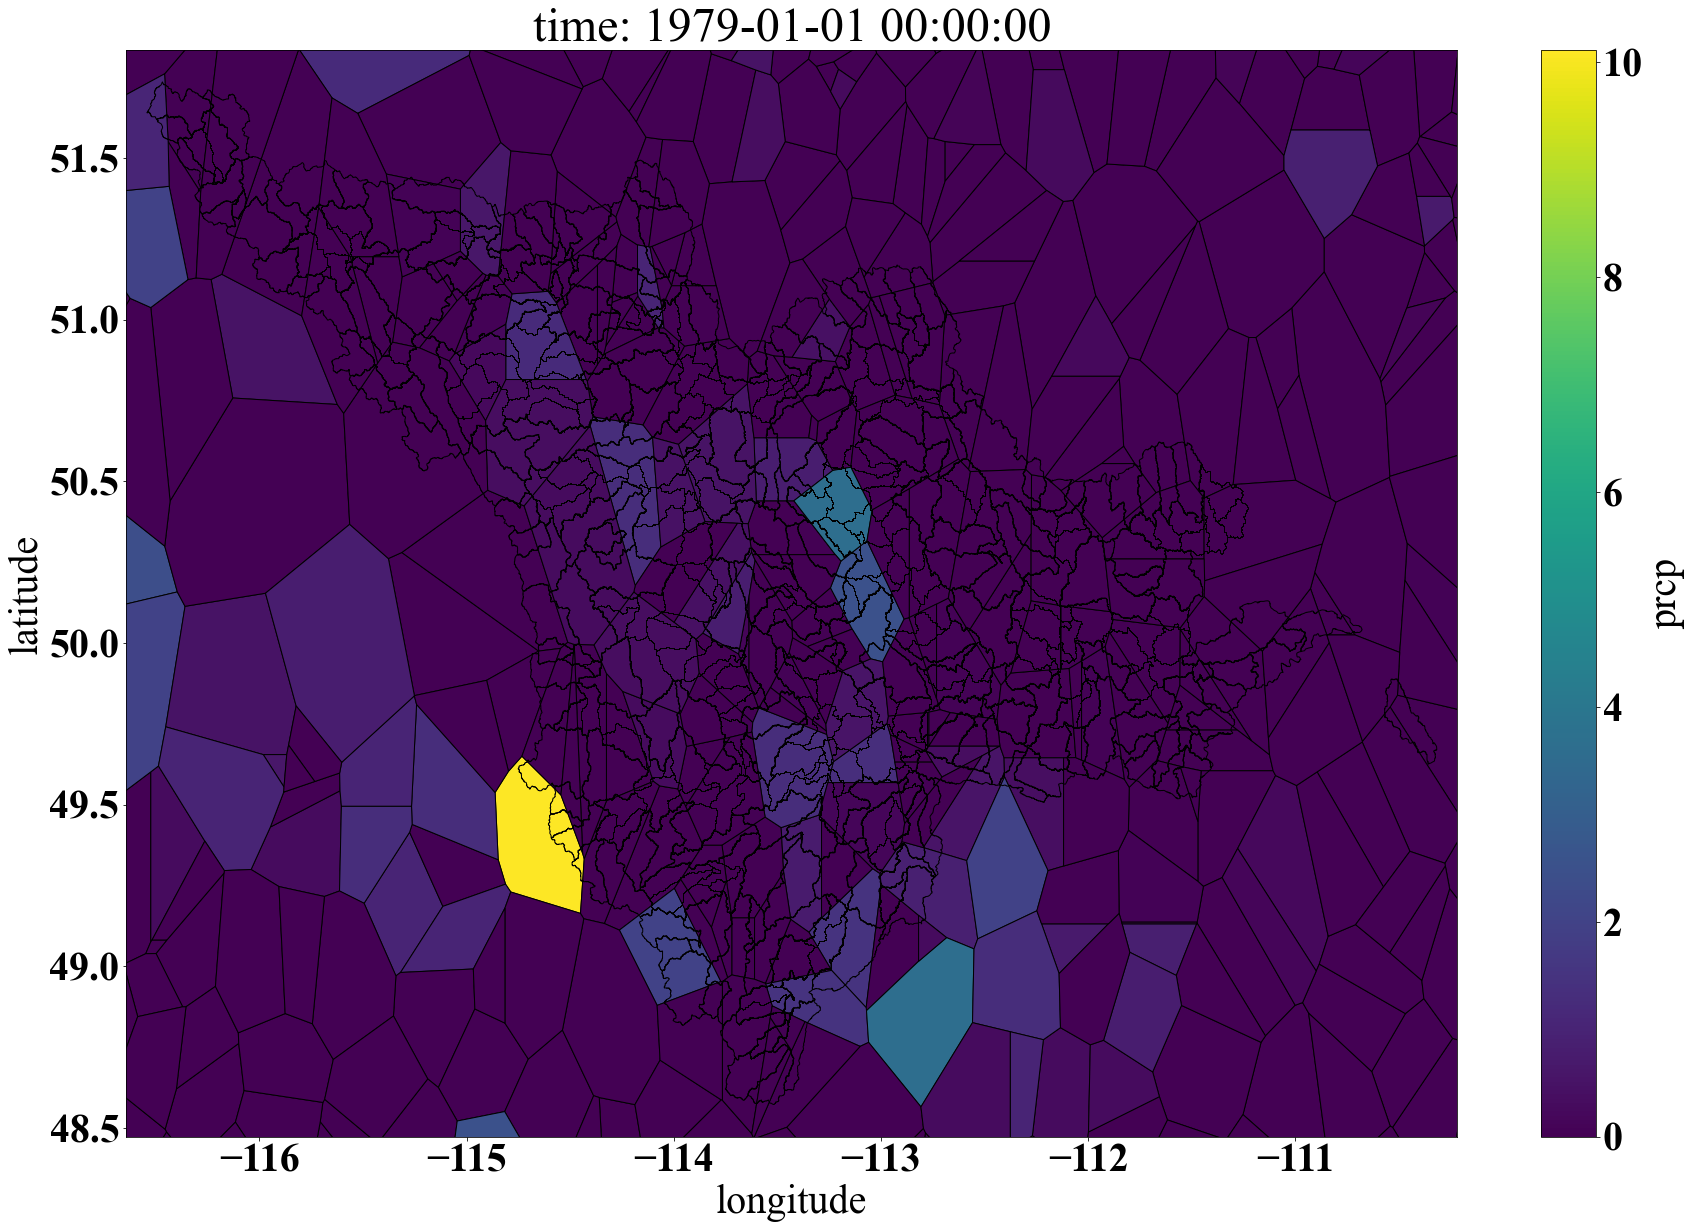

In [16]:
####
#sys.modules[__name__].__dict__.clear() # for python
####
# %reset  # for jupyter notebbok OR
####
d = dir()
for obj in d:
    #checking for built-in variables/functions
    if not obj.startswith('__'):
        #deleting the said obj, since a user-defined function
        del globals()[obj]

# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()


# set the paramaters
source_nc_name                  = '../temporary/SCDNA/SCDNA_v1.1_prcp_1979.nc' # name of source nc file
source_nc_var_lon               = "Longitude" # lon in the source nc file
source_nc_var_lat               = "Latitude" # lat in the source nc file
source_nc_var_ID                = "ID" # ID in the source nc file
source_nc_var_time              = 'time' # variable time in the source nc file
source_nc_var_name              = 'prcp'# variable from the source nc file
source_shp_name                 = '../temporary/SCDNA_Medicine_Hat_source_shapefile.shp' # source shapefile if case 3 such as station data; should be given or generated by EASYMORE
source_shp_field_ID             = "ID_s" # the ID of the source shapefile
remapped_nc_name                = '../output/SCDNA_Medicine_Hat_remapped_1979-01-01-00-00-00.nc' #'../output/ERA5_Medicine_Hat_remapped_1979-01-03-00-00-00.nc' # the remapped nc file
remapped_nc_var_ID              = "ID" # the ID from shapefile that match with remapped files
remapped_nc_var_time            = "time" # the varibale time in the nc file
remapped_nc_var_name            = 'prcp' # the variable name in the remapped file
shp_target_name                 = '../temporary/ERA5_Medicine_Hat_target_shapefile.shp' # the target shapefile
shp_target_filed_ID             = 'ID_t' # the field of the attribute that link the shapefile to remapped nc file
time_step_of_viz                = '1970-01-01 00:00:00' # it should be in form of 1990-02-01 00:00:00 
location_save_fig               = '../fig/' # location where the fig should be saved
file_name                       = 'test2.pdf' # the file name of the figure
fig_size                        = (30,20) # the figure size
show_target_shp_flag            = True # to show the target shapefile on top of the gridded data
show_remapped_values_flag       = False # to show the target shapefile with its remapped variables
cmap                            = 'viridis' # the color 
margin                          = 0.1 # margin in degrees
linewidth                       = 1 # linewidth for shapefile
font_size                       = 40 # font size
font_family                     = 'Times New Roman' # name of the font type
font_weigth                     = 'bold' # to be bold
add_colorbar_flag               = True # flag to add colorbar
min_lon,min_lat,max_lon,max_lat = None, None, None, None # if there is lat/lon to zoom in

# execute EASYMORE
esmr.nc_remapper_vis(source_nc_name                  = source_nc_name,
                     source_nc_var_lon               = source_nc_var_lon,
                     source_nc_var_lat               = source_nc_var_lat,
                     source_nc_var_ID                = source_nc_var_ID,
                     source_nc_var_time              = source_nc_var_time,
                     source_nc_var_name              = source_nc_var_name,
                     source_shp_name                 = source_shp_name,
                     source_shp_field_ID             = source_shp_field_ID,
                     remapped_nc_name                = remapped_nc_name, 
                     remapped_nc_var_ID              = remapped_nc_var_ID,
                     remapped_nc_var_time            = remapped_nc_var_time,
                     remapped_nc_var_name            = remapped_nc_var_name,
                     shp_target_name                 = shp_target_name,
                     shp_target_filed_ID             = shp_target_filed_ID,
                     time_step_of_viz                = time_step_of_viz,
                     location_save_fig               = location_save_fig,
                     fig_name                        = file_name,
                     fig_size                        = fig_size,
                     show_target_shp_flag            = show_target_shp_flag,
                     show_remapped_values_flag       = show_remapped_values_flag,
                     cmap                            = cmap,
                     margin                          = margin,
                     linewidth                       = linewidth,
                     font_size                       = font_size,
                     font_family                     = font_family,
                     font_weigth                     = font_weigth,
                     add_colorbar_flag               = add_colorbar_flag,
                     min_lon                         = min_lon,
                     min_lat                         = min_lat,
                     max_lon                         = max_lon,
                     max_lat                         = max_lat)

# delete all the varibales not to interfer with next visualziation of use sys
# import sys; sys.modules[__name__].__dict__.clear()
# del source_nc_name, source_nc_var_lon, source_nc_var_lat, source_nc_var_ID, source_nc_var_time
# del source_nc_var_name, source_shp_name, source_shp_field_ID, source_shp_name
# del source_shp_field_ID, remapped_nc_name, remapped_nc_var_ID, remapped_nc_var_time, remapped_nc_var_name
# del shp_target_name, shp_target_filed_ID, time_step_of_viz, location_save_fig, file_name, fig_size
# del show_target_shp_flag, show_target_shp_flag, show_remapped_values_flag, cmap, margin, linewidth, font_size
# del font_family, font_weigth, add_colorbar_flag, min_lon,min_lat,max_lon,max_lat


EASYMORE version 0.0.5 is initiated.
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detects that no varibale for ID of the source netCDF file; an arbitatiry ID will be provided
1979-01-01 00:00:00


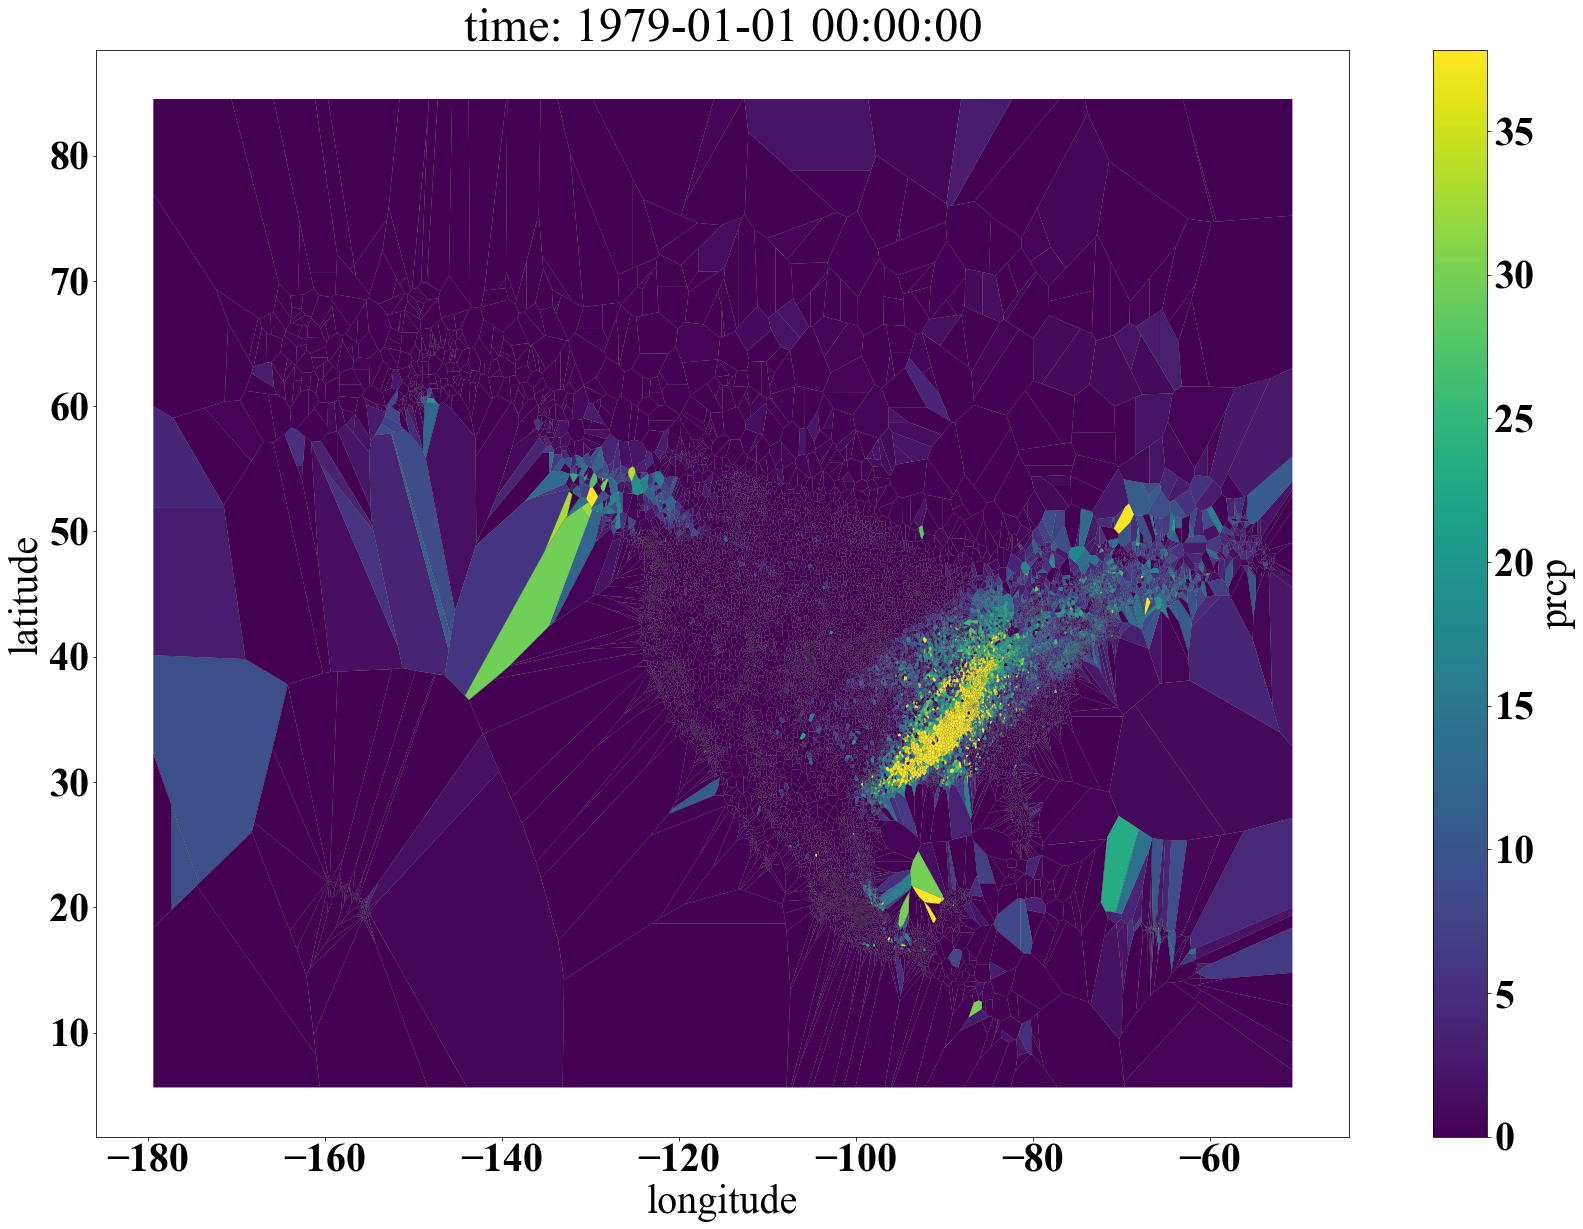

In [17]:
####
#sys.modules[__name__].__dict__.clear() # for python
####
# %reset  # for jupyter notebbok OR
####
d = dir()
for obj in d:
    #checking for built-in variables/functions
    if not obj.startswith('__'):
        #deleting the said obj, since a user-defined function
        del globals()[obj]

# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()


# set the paramaters
source_nc_name                  = '../temporary/SCDNA/SCDNA_v1.1_prcp_1979.nc' # name of source nc file
source_nc_var_lon               = "Longitude" # lon in the source nc file
source_nc_var_lat               = "Latitude" # lat in the source nc file
source_nc_var_ID                = "ID" # ID in the source nc file
source_nc_var_time              = 'time' # variable time in the source nc file
source_nc_var_name              = 'prcp'# variable from the source nc file
source_shp_name                 = '../temporary/SCDNA_Medicine_Hat_source_shapefile.shp' # source shapefile if case 3 such as station data; should be given or generated by EASYMORE
source_shp_field_ID             = "ID_s" # the ID of the source shapefile
time_step_of_viz                = '1970-01-01 00:00:00' # it should be in form of 1990-02-01 00:00:00 
location_save_fig               = '../fig/' # location where the fig should be saved
file_name                       = 'test2.pdf' # the file name of the figure
fig_size                        = (30,20) # the figure size
show_target_shp_flag            = True # to show the target shapefile on top of the gridded data
show_remapped_values_flag       = True # to show the target shapefile with its remapped variables
cmap                            = 'viridis' # the color 
margin                          = 0.1 # margin in degrees
linewidth                       = 0.1 # linewidth for shapefile
font_size                       = 40 # font size
font_family                     = 'Times New Roman' # name of the font type
font_weigth                     = 'bold' # to be bold
add_colorbar_flag               = True # flag to add colorbar
min_lon,min_lat,max_lon,max_lat = None, None, None, None # if there is lat/lon to zoom in

# execute EASYMORE
esmr.nc_remapper_vis(source_nc_name                  = source_nc_name,
                     source_nc_var_lon               = source_nc_var_lon,
                     source_nc_var_lat               = source_nc_var_lat,
                     source_nc_var_ID                = source_nc_var_ID,
                     source_nc_var_time              = source_nc_var_time,
                     source_nc_var_name              = source_nc_var_name,
                     source_shp_name                 = source_shp_name,
                     source_shp_field_ID             = source_shp_field_ID,
                     time_step_of_viz                = time_step_of_viz,
                     location_save_fig               = location_save_fig,
                     fig_name                        = file_name,
                     fig_size                        = fig_size,
                     show_target_shp_flag            = show_target_shp_flag,
                     show_remapped_values_flag       = show_remapped_values_flag,
                     cmap                            = cmap,
                     margin                          = margin,
                     linewidth                       = linewidth,
                     font_size                       = font_size,
                     font_family                     = font_family,
                     font_weigth                     = font_weigth,
                     add_colorbar_flag               = add_colorbar_flag,
                     min_lon                         = min_lon,
                     min_lat                         = min_lat,
                     max_lon                         = max_lon,
                     max_lat                         = max_lat)